In [2]:
import pandas as pd

ppg_data = pd.read_csv("../myfile_new.csv")

<Axes: >

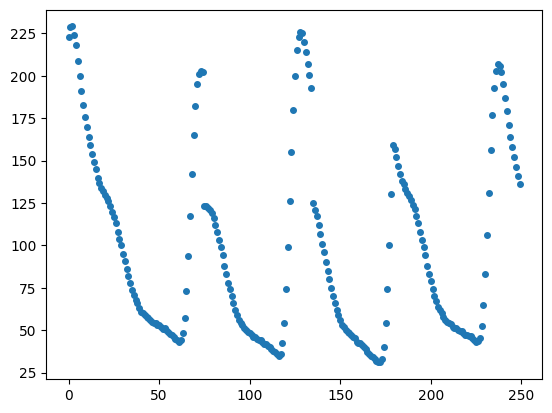

In [3]:
ppg_data['ASP_col'].iloc[0:250].plot(style='o', markersize=4)

In [ ]:
import numpy as np

# Example signal
signal = ppg_data['ASP_col'].values
n = len(signal)
q_table = np.zeros((n, 3))  # states x actions (left, right, mark)

def is_peak(idx):
    if idx == 0 or idx == n-1:
        return False
    return signal[idx] > signal[idx-1] and signal[idx] > signal[idx+1]

alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

for ep in range(episodes):
    state = np.random.randint(1, n-1) # randomly choosing the inital state?
    done = False
    while not done:
        if np.random.rand() < epsilon: # some monte-carlo exploration? 
            action = np.random.choice(3) # why a random action?
        else:
            action = np.argmax(q_table[state])
        next_state = state
        reward = 0
        if action == 0:  # left
            next_state = max(1, state-1)
            # reward = -1
        elif action == 1:  # right
            next_state = min(n-2, state+1)
            # reward = -1
        elif action == 2:  # mark as peak
            if is_peak(state):
                reward = 1
            else:
                reward = -1
            done = True
        q_table[state, action] += alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
        state = next_state

# After training, extract peaks
peaks = [i for i in range(1, n-1) if np.argmax(q_table[i]) == 2]
print("Detected peaks at indices:", peaks)

Detected peaks at indices: [2, 48, 50, 53, 73, 76, 103, 106, 109, 128, 161, 179, 214, 222, 237, 282, 287, 289, 300, 340, 359, 406, 429, 473, 478, 494, 525, 528, 534, 540, 576, 580, 586, 604, 629, 631, 633, 649, 679, 697, 743, 746, 762, 805, 808, 810, 825, 842, 844, 874, 889, 933, 940, 970, 994, 1013, 1037, 1043, 1059, 1104, 1114, 1126, 1172, 1176, 1178, 1195, 1223, 1226, 1229, 1231, 1247, 1290, 1297, 1299, 1316, 1346, 1349, 1355, 1357, 1371, 1415, 1424, 1439, 1464, 1487, 1505, 1528, 1534, 1544, 1573, 1579, 1589, 1597, 1634, 1639, 1660, 1666, 1679, 1710, 1712, 1726, 1771, 1774, 1788, 1806, 1835, 1839, 1853, 1868, 1870, 1873, 1892, 1894, 1897, 1902, 1916]


In [36]:
q_table

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.65628632e+00, -7.94108868e-01],
       [ 2.41468021e+00,  4.53485667e+00,  9.74482036e+00],
       ...,
       [ 1.33277714e-03,  0.00000000e+00,  0.00000000e+00],
       [ 1.60789283e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
      shape=(1935, 3))

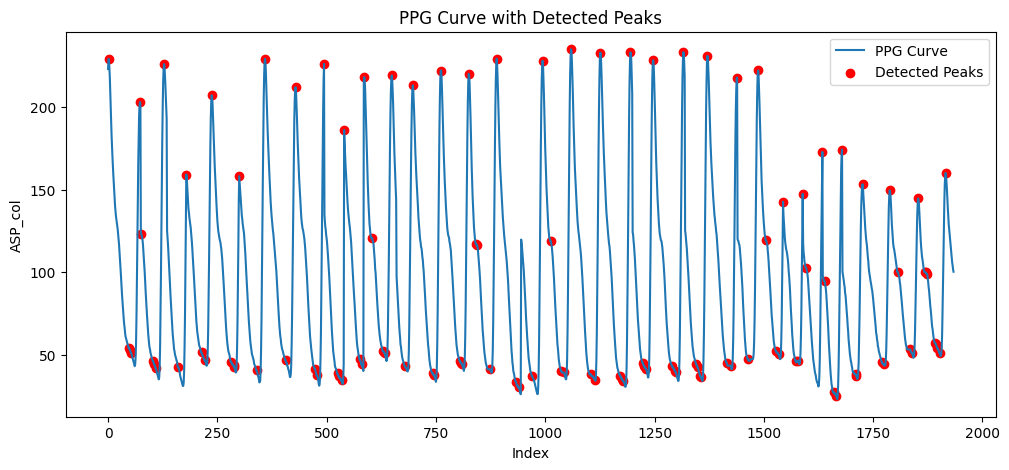

In [37]:
# peaks = [540, 585, 945]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(ppg_data['ASP_col'], label='PPG Curve')
plt.scatter(peaks, ppg_data['ASP_col'].iloc[peaks], color='red', label='Detected Peaks')
plt.xlabel('Index')
plt.ylabel('ASP_col')
plt.title('PPG Curve with Detected Peaks')
plt.legend()
plt.show()

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# Example signal
signal = ppg_data['ASP_col'].values
n = len(signal)

# ---- Helper functions ----
def is_peak(idx):
    if idx == 0 or idx == n-1:
        return False
    return signal[idx] > signal[idx-1] and signal[idx] > signal[idx+1]

def get_state(idx):
    """Return feature vector for a given index."""
    if idx == 0 or idx == n-1:
        return np.array([0.0, 0.0, 0.0], dtype=np.float32)
    val = signal[idx]
    slope = signal[idx] - signal[idx-1]
    curvature = signal[idx+1] - 2*signal[idx] + signal[idx-1]
    return np.array([val, slope, curvature], dtype=np.float32)

# ---- Parameters ----
alpha = 0.001       # learning rate
gamma = 0.9         # discount factor
epsilon = 1.0       # initial exploration
epsilon_min = 0.05
epsilon_decay = 0.995
episodes = 500
max_steps = 200

# ---- Build Q-network ----
model = tf.keras.Sequential([
    layers.Input(shape=(3,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='linear')  # 3 actions: left, right, mark
])
optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)
loss_fn = tf.keras.losses.MeanSquaredError()

# ---- Training loop ----
for ep in range(episodes):
    state_idx = np.random.randint(1, n-1)
    state = get_state(state_idx)
    done = False
    steps = 0
    
    while not done and steps < max_steps:
        steps += 1
        
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.choice(3)
        else:
            q_vals = model.predict(state[np.newaxis], verbose=0)[0]
            action = np.argmax(q_vals)
        
        # Transition
        next_idx = state_idx
        reward = 0
        
        if action == 0:  # move left
            next_idx = max(1, state_idx-1)
        elif action == 1:  # move right
            next_idx = min(n-2, state_idx+1)
        elif action == 2:  # mark
            if is_peak(state_idx):
                reward = 1.0
            else:
                reward = -1.0
            done = True
        
        # Reward shaping (encourage approaching peaks)
        if not done:
            if is_peak(next_idx):
                reward = 0.2
            else:
                reward = -0.01
        
        next_state = get_state(next_idx)
        
        # Q-learning update via gradient descent
        with tf.GradientTape() as tape:
            q_vals = model(state[np.newaxis], training=True)
            q_val = q_vals[0, action]
            
            next_q_vals = model(next_state[np.newaxis], training=False)
            target = reward + (0 if done else gamma * np.max(next_q_vals))
            
            loss = loss_fn([target], [q_val])
        
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        state_idx = next_idx
        state = next_state
    
    # Decay epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# ---- Extract peaks after training ----
peaks = []
for i in range(1, n-1):
    state = get_state(i)
    q_vals = model.predict(state[np.newaxis], verbose=0)[0]
    if np.argmax(q_vals) == 2:  # action "mark"
        peaks.append(i)

print("Detected peaks at indices:", peaks)


2025-08-20 19:34:40.082500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-20 19:34:40.082745: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 19:34:40.121077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-20 19:34:44.895363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Detected peaks at indices: [540, 585, 945]
